In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [9]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 50)            1150      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 128)           19328     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 29, 64)            16448     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

# 1. Make Data X_train, y_train, X_test, y_test

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [5]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

inp = open(file_path+'detect_peptide_train_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_y_noptm.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_y_noptm.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_y_noptm.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_y_noptm.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

Loading input peptides
Succesfully loaded 177997 peptides and skipped 0
Loading input peptides
Succesfully loaded 44499 peptides and skipped 0
(142397, 30) (35600, 30) (44499, 30) (142397,) (35600,) (44499,)


# 2. train

In [6]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [10]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 142397 samples, validate on 35600 samples
Epoch 1/200
142397/142397 [==============================] - 23s 161us/sample - loss: 0.6257 - acc: 0.7120 - val_loss: 0.5896 - val_acc: 0.8112
Epoch 2/200
142397/142397 [==============================] - 23s 160us/sample - loss: 0.5891 - acc: 0.8162 - val_loss: 0.5860 - val_acc: 0.8228
Epoch 3/200
142397/142397 [==============================] - 23s 159us/sample - loss: 0.5873 - acc: 0.8214 - val_loss: 0.5853 - val_acc: 0.8224
Epoch 4/200
142397/142397 [==============================] - 22s 156us/sample - loss: 0.5864 - acc: 0.8235 - val_loss: 0.5844 - val_acc: 0.8272
Epoch 5/200
142397/142397 [==============================] - 22s 156us/sample - loss: 0.5857 - acc: 0.8248 - val_loss: 0.5840 - val_acc: 0.8308
Epoch 6/200
142397/142397 [==============================] - 23s 158us/sample - loss: 0.5853 - acc: 0.8255 - val_loss: 0.5838 - val_acc: 0.8292
Epoch 7/200
142397/142397 [==============================] - 23s 165us/sample - loss:

142397/142397 [==============================] - 17s 121us/sample - loss: 0.5730 - acc: 0.8498 - val_loss: 0.5729 - val_acc: 0.8489
Epoch 58/200
142397/142397 [==============================] - 17s 122us/sample - loss: 0.5731 - acc: 0.8493 - val_loss: 0.5727 - val_acc: 0.8457
Epoch 59/200
142397/142397 [==============================] - 17s 122us/sample - loss: 0.5730 - acc: 0.8494 - val_loss: 0.5740 - val_acc: 0.8554
Epoch 60/200
142397/142397 [==============================] - 17s 122us/sample - loss: 0.5729 - acc: 0.8500 - val_loss: 0.5735 - val_acc: 0.8416
Epoch 61/200
142397/142397 [==============================] - 17s 122us/sample - loss: 0.5728 - acc: 0.8501 - val_loss: 0.5730 - val_acc: 0.8474
Epoch 62/200
142397/142397 [==============================] - 18s 123us/sample - loss: 0.5727 - acc: 0.8507 - val_loss: 0.5721 - val_acc: 0.8494
Epoch 63/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5724 - acc: 0.8511 - val_loss: 0.5721 - val_acc: 0.853

142397/142397 [==============================] - 18s 124us/sample - loss: 0.5685 - acc: 0.8594 - val_loss: 0.5699 - val_acc: 0.8567
Epoch 114/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5686 - acc: 0.8586 - val_loss: 0.5708 - val_acc: 0.8576
Epoch 115/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5688 - acc: 0.8580 - val_loss: 0.5713 - val_acc: 0.8456
Epoch 116/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5688 - acc: 0.8585 - val_loss: 0.5699 - val_acc: 0.8603
Epoch 117/200
142397/142397 [==============================] - 17s 122us/sample - loss: 0.5687 - acc: 0.8589 - val_loss: 0.5698 - val_acc: 0.8566
Epoch 118/200
142397/142397 [==============================] - 18s 123us/sample - loss: 0.5685 - acc: 0.8594 - val_loss: 0.5697 - val_acc: 0.8535
Epoch 119/200
142397/142397 [==============================] - 17s 120us/sample - loss: 0.5686 - acc: 0.8585 - val_loss: 0.5697 - val_acc:

142397/142397 [==============================] - 19s 131us/sample - loss: 0.5668 - acc: 0.8627 - val_loss: 0.5689 - val_acc: 0.8566
Epoch 170/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5666 - acc: 0.8633 - val_loss: 0.5695 - val_acc: 0.8522
Epoch 171/200
142397/142397 [==============================] - 18s 126us/sample - loss: 0.5669 - acc: 0.8622 - val_loss: 0.5691 - val_acc: 0.8553
Epoch 172/200
142397/142397 [==============================] - 18s 125us/sample - loss: 0.5668 - acc: 0.8627 - val_loss: 0.5689 - val_acc: 0.8562
Epoch 173/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5664 - acc: 0.8633 - val_loss: 0.5690 - val_acc: 0.8596
Epoch 174/200
142397/142397 [==============================] - 18s 129us/sample - loss: 0.5665 - acc: 0.8630 - val_loss: 0.5695 - val_acc: 0.8578
Epoch 175/200
142397/142397 [==============================] - 18s 124us/sample - loss: 0.5667 - acc: 0.8633 - val_loss: 0.5691 - val_acc:

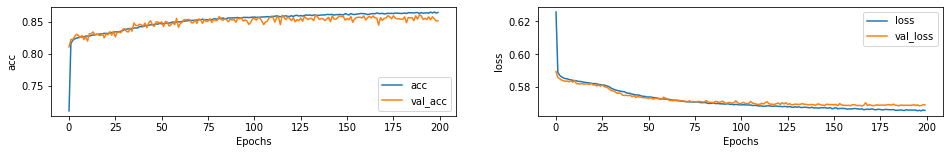

In [11]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'acc')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

44499/44499 [==============================] - 3s 70us/sample - loss: 0.5712 - acc: 0.8516
Test Loss: 0.5712375338285054
Test Accuracy: 0.8515921831130981


              precision    recall  f1-score   support

           0       0.82      0.90      0.86     22330
           1       0.89      0.80      0.84     22169

    accuracy                           0.85     44499
   macro avg       0.86      0.85      0.85     44499
weighted avg       0.86      0.85      0.85     44499

rf auc : 0.9162440645210932


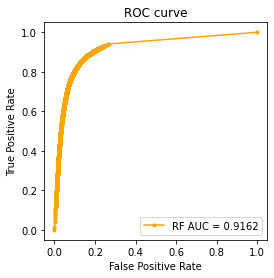

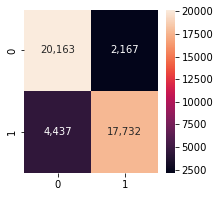

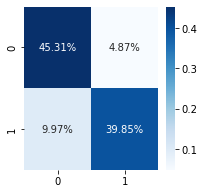

In [14]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()